In [1]:

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

In [2]:
#Read the csv file
df = pd.read_csv('AAPL.csv')
print(df.head()) #7 columns, including the Date. 


         Date       Open       High        Low      Close  Adj Close  \
0  2019-04-29  51.099998  51.492500  50.965000  51.152500  49.244457   
1  2019-04-30  50.764999  50.849998  49.777500  50.167500  48.296200   
2  2019-05-01  52.470001  53.827499  52.307499  52.630001  50.666843   
3  2019-05-02  52.459999  53.162498  52.032501  52.287498  50.337112   
4  2019-05-03  52.722500  52.959999  52.557499  52.937500  50.962868   

      Volume  
0   88818800  
1  186139600  
2  259309200  
3  127985200  
4   83569600  


In [3]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 


1244   2024-04-08
1245   2024-04-09
1246   2024-04-10
1247   2024-04-11
1248   2024-04-12
1249   2024-04-15
1250   2024-04-16
1251   2024-04-17
1252   2024-04-18
1253   2024-04-19
1254   2024-04-22
1255   2024-04-23
1256   2024-04-24
1257   2024-04-25
1258   2024-04-26
Name: Date, dtype: datetime64[ns]


In [4]:
#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols)

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [5]:
df_for_training = df[cols].astype(float)

In [6]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)


In [7]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

In [8]:
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.


In [9]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [10]:

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (1245, 14, 5).
trainY shape == (1245, 1).


In [11]:

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

2024-05-13 15:48:40.875797: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-05-13 15:48:40.875838: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-13 15:48:40.875847: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-13 15:48:40.875879: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-13 15:48:40.875901: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/miniconda3/envs/TFmacOS/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 14, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


2024-05-13 15:48:45.409810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 200ms/step - loss: 0.5108 - val_loss: 0.0150
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 197ms/step - loss: 0.0691 - val_loss: 0.0162
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 197ms/step - loss: 0.0537 - val_loss: 0.0230
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 197ms/step - loss: 0.0474 - val_loss: 0.0071
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 197ms/step - loss: 0.0490 - val_loss: 0.0094


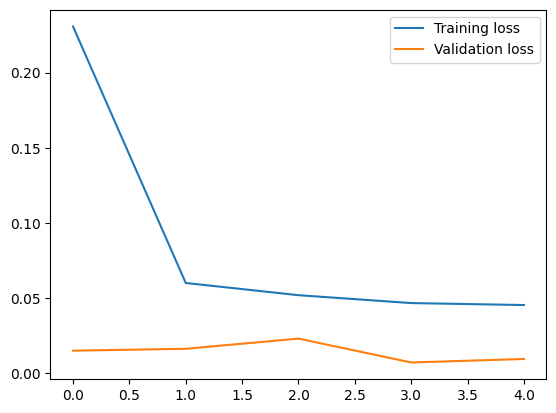

In [12]:

# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [13]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 40
n_days_for_prediction=55  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

[Timestamp('2024-03-01 00:00:00'), Timestamp('2024-03-04 00:00:00'), Timestamp('2024-03-05 00:00:00'), Timestamp('2024-03-06 00:00:00'), Timestamp('2024-03-07 00:00:00'), Timestamp('2024-03-08 00:00:00'), Timestamp('2024-03-11 00:00:00'), Timestamp('2024-03-12 00:00:00'), Timestamp('2024-03-13 00:00:00'), Timestamp('2024-03-14 00:00:00'), Timestamp('2024-03-15 00:00:00'), Timestamp('2024-03-18 00:00:00'), Timestamp('2024-03-19 00:00:00'), Timestamp('2024-03-20 00:00:00'), Timestamp('2024-03-21 00:00:00'), Timestamp('2024-03-22 00:00:00'), Timestamp('2024-03-25 00:00:00'), Timestamp('2024-03-26 00:00:00'), Timestamp('2024-03-27 00:00:00'), Timestamp('2024-03-28 00:00:00'), Timestamp('2024-03-29 00:00:00'), Timestamp('2024-04-01 00:00:00'), Timestamp('2024-04-02 00:00:00'), Timestamp('2024-04-03 00:00:00'), Timestamp('2024-04-04 00:00:00'), Timestamp('2024-04-05 00:00:00'), Timestamp('2024-04-08 00:00:00'), Timestamp('2024-04-09 00:00:00'), Timestamp('2024-04-10 00:00:00'), Timestamp('20

In [14]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


In [15]:
	
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

/var/folders/yx/5jjp6rf14xgfy9jgfxf60bch0000gn/T/ipykernel_1372/2889940138.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date'] = pd.to_datetime(original['Date'])


<Axes: xlabel='Date', ylabel='Open'>

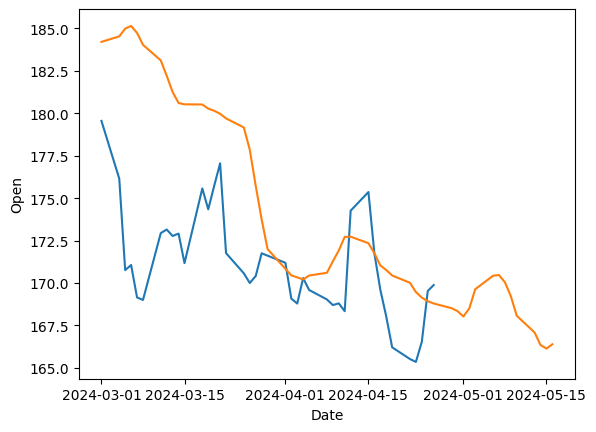

In [16]:
# Assuming predict_period_dates and y_pred_future are defined elsewhere

# Convert timestamp to date for forecast data
forecast_dates = [time_i.date() for time_i in predict_period_dates]
df_forecast = pd.DataFrame({'Date': forecast_dates, 'Open': y_pred_future})
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

# Assuming df is your original DataFrame
# Filter the original DataFrame and convert 'Date' to datetime
original = df[['Date', 'Open']]
original['Date'] = pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2024-03-01']  # Ensure correct date format

# Plotting using seaborn
sns.lineplot(data=original, x='Date', y='Open')
sns.lineplot(data=df_forecast, x='Date', y='Open')